In [1]:
import os
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark import SparkContext 
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, DecimalType, ArrayType
import pyspark.sql.functions as F
from pyspark import StorageLevel
from pyspark.sql.window import Window


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


### Uso do Spark

Foi utilizando o Spark para obter maior performance com processamento em memória dos dados de origem


In [2]:
spark = SparkSession.builder.master("local[1]") \
    .appName("SparkByExamples.com") \
    .config("spark.executor.memory","8G") \
    .config("spark.driver.memory","8G") \
    .config("spark.executor.cores","12") \
    .getOrCreate()

23/03/12 14:06:28 WARN Utils: Your hostname, daholive-Dell-G15-5510 resolves to a loopback address: 127.0.1.1; using 192.168.0.114 instead (on interface wlp0s20f3)
23/03/12 14:06:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/12 14:06:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
relative_path = os.path.abspath('.')

In [4]:
dados_path = relative_path + "/dados/"

In [ ]:
csv_list = [dados_path+item for item in os.listdir(dados_path)]
csv_list

In [ ]:
df = spark.read.option("header",True).csv(csv_list)

In [ ]:
df = df.persist(StorageLevel.MEMORY_ONLY)

In [ ]:
df.printSchema()

## Data Describe

- The readings occur every 4 hours
- The 4-hour observation windows are not the same for all turnstiles
- Some of the turnstiles are counting down, not up. ¯\_(ツ)_/¯
- Each turnstile that’s keeping track of counts is identified by its “subunit channel position” or scp, unique within a control area.
- Each turnstile is in a “control area”, which is the bank of turnstiles associated with a subway exit or exits, unique within a remote unit.
- Each control area is in a “remote unit”. Remote unit generally represents a single station, but some stations and station complexes have several associated remote unit ids.

## Important observation

The most important thing to know is that the entries and exits columns are not counts of people for a given timeframe, they are more like odometer readings. To know how many entries there were at a given observation, you must know the reading from the previous observation and calculate the difference.

## Modification RAW Data

To make life easier, a few modifications to the raw data are made:

- Combine the date and time columns into a proper timestamp named observed_at. This allows us to use the database’s time functions to quickly group by day.
- Concatenate remoteunit, controlarea, scp , and timestamp into id , and enforce uniqueness. This prevents duplicate observations for the same turnstile and timestamp (these exist in the raw data for various reasons)
- Concatenate remoteunit, controlarea, andscp into unit_id , which describes a single turnstile. This is useful for calculating the net entries and exits

One big caveat: We also never allownet_entries or net_exits to be greater than 10,000. Because the turnstile readings are like odometers, they can only count so high. When they roll over, the result is astronomically large net values that need to be thrown out. 10,000 is a reasonable cutoff for excluding these errant calculations, as it represents 2,500 persons per hour passing through a turnstile, or 41 persons per minute.


In [ ]:
windowSpecEntries = Window.partitionBy(F.col('unit_id')).orderBy(
    F.col('observed_at')
)

In [ ]:
df = df.withColumn(
    'observed_at', F.to_timestamp('time')
).withColumn(
    'id', F.concat_ws('|', 
        F.col('unit'),
        F.col('ca'),
        F.col('scp'),
        F.col('observed_at')
    )
).withColumn(
    'unit_id', F.concat_ws('|', 
        F.col('unit'),
        F.col('ca'),
        F.col('scp')
    )
).withColumn(
    'calc_net_entries',F.col("entries") - F.lag("entries", 1).over(windowSpecEntries)
).withColumn(
    'calc_net_exits',F.col("exits") - F.lag("exits", 1).over(windowSpecEntries)
).withColumn(
    'hours_difference', ((F.date_format(F.col("observed_at"),"d") - F.date_format(F.lag("observed_at", 1).over(windowSpecEntries),"d")) * 24) +
                (F.date_format(F.col("observed_at"),"H") - F.date_format(F.lag("observed_at", 1).over(windowSpecEntries),"H"))
).withColumn(
    'net_entries', F.when(
        (F.abs('calc_net_entries') < 10000) & (F.col('hours_difference') <= 24), F.abs('calc_net_entries')
    ).otherwise(F.lit(0))
).withColumn(
    'net_exits', F.when(
        (F.abs('calc_net_exits') < 10000) & (F.col('hours_difference') <= 24), F.abs('calc_net_exits')
    ).otherwise(F.lit(0))
)

In [ ]:
df.printSchema()

## Daily Counts by individual turnstile

#### Now aggregate into daily counts for each unit_id. Add 2 hours to observed_at for deciding which date it should fall into. (midnight falls to following day, meaning a 4-hour observation period ending at midnight gets counted on the next day, which is bad. With a 2 hour offset, observations through 1:59am will count to the previous day)



In [ ]:
df_daily_subunit = df.groupBy(
    F.col('station'),
    F.col('linename'),
    F.col('unit_id'),
    F.date_format(F.date_trunc('day',F.expr("observed_at - INTERVAL 2 HOURS")),'yyyy-MM-dd').alias('date')
).agg(
    F.array_distinct(F.collect_list('unit')).getItem(0).alias('unit'),
    F.sum('net_entries').alias('entries'),
    F.sum('net_exits').alias('exits'),
)

In [ ]:
df_daily_subunit.count()

### CHECKPOINT 1

In [ ]:
(df_daily_subunit
 .repartition(1)
 .write
 .option('mergeSchema', 'true')
 .option('overwriteSchema', 'true')
 .save(relative_path+"/nyc_subway_traffic_data", mode='overwrite')) 

## EXPLORATORY DATA ANALYSIS

In [5]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [64]:
dataframe = spark.read.parquet(relative_path+"/nyc_subway_traffic_data")

In [65]:
dataframe = dataframe.persist(StorageLevel.MEMORY_ONLY)

23/03/12 14:29:20 WARN CacheManager: Asked to cache already cached data.


In [66]:
dataframe.count()

12047689

In [67]:
dataframe.printSchema()

root
 |-- station: string (nullable = true)
 |-- linename: string (nullable = true)
 |-- unit_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- entries: double (nullable = true)
 |-- exits: double (nullable = true)



## NEW FEATURES

Creating new features to evaluate data distribution over time

In [68]:
dataframe = dataframe.withColumn(
    'month', F.date_format('date','yyyy-MM')
).withColumn(
    'year', F.year('date')
).withColumn(
    'dayofweek', F.dayofweek('date')
).withColumn(
    'weekofyear', F.weekofyear('date')
).withColumn(
    'traffic', F.col('entries') + F.col('exits')
).filter(
    (F.col('entries')!=0) & (F.col('exits')!=0)
)

In [69]:
dataframe.show()

+-------+--------+------------------+----------+----+-------+------+-------+----+---------+----------+-------+
|station|linename|           unit_id|      date|unit|entries| exits|  month|year|dayofweek|weekofyear|traffic|
+-------+--------+------------------+----------+----+-------+------+-------+----+---------+----------+-------+
|   null|    null|R028|A082|05-05-01|2014-08-30|R028|    1.0|   2.0|2014-08|2014|        7|        35|    3.0|
|   null|    null|R168|R169|01-03-01|2012-11-03|R168| 1514.0|2058.0|2012-11|2012|        7|        44| 3572.0|
|   null|    null|R168|R169|01-03-01|2012-11-04|R168| 1393.0|2479.0|2012-11|2012|        1|        44| 3872.0|
|   null|    null|R168|R169|01-03-01|2012-11-05|R168| 2423.0|4794.0|2012-11|2012|        2|        45| 7217.0|
|   null|    null|R168|R169|01-03-01|2012-11-06|R168| 2678.0|4741.0|2012-11|2012|        3|        45| 7419.0|
|   null|    null|R168|R169|01-03-01|2012-11-07|R168| 2530.0|4515.0|2012-11|2012|        4|        45| 7045.0|
|

In [36]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df_pandas = dataframe.toPandas()

In [70]:
import pyspark

def spark_shape(self):
    return (self.count(), len(self.columns))
    
pyspark.sql.dataframe.DataFrame.shape = spark_shape

### Sampling method

I decided to use a sampling method that has a 99% confidence level.

In [71]:
# nivel confianca 99%
# z = 2.58
z = 2.58
p = 0.5
e = 0.01
N = dataframe.shape()[0]

In [73]:
amostra = ((z**2)*(p*(1-p))/(e**2))
amostra

16641.0

In [74]:
fraction = amostra / N
fraction

0.0015728165580410991

In [75]:
df_sample = dataframe.sample(fraction,43)

In [76]:
df_sample.count()

16930

## Exploratory Analysis with Pandas Dataframe

In [77]:
df_pandas = df_sample.toPandas()

In [78]:
df_pandas

,station,linename,unit_id,date,unit,entries,exits,month,year,dayofweek,weekofyear,traffic
0,None,None,R168|R169|01-03-01,2013-01-10,R168,2075.00,4331.00,2013-01,2013,5,2,6406.00
1,None,None,R168|R169|01-03-02,2013-02-09,R168,1637.00,1407.00,2013-02,2013,7,6,3044.00
2,None,None,R168|R169|01-03-02,2013-06-30,R168,1599.00,1907.00,2013-06,2013,1,26,3506.00
3,110 ST,6,R181|R253|00-00-01,2011-01-26,R181,1245.00,1892.00,2011-01,2011,4,4,3137.00
4,110 ST,6,R181|R253|00-00-01,2012-06-01,R181,953.00,2113.00,2012-06,2012,6,22,3066.00
...,...,...,...,...,...,...,...,...,...,...,...,...
16925,STILLWELL AVE,DFNQ,R151|G001|00-03-01,2012-06-12,R151,436.00,165.00,2012-06,2012,3,24,601.00
16926,STILLWELL AVE,DFNQ,R151|G001|00-03-01,2015-04-16,R151,438.00,183.00,2015-04,2015,5,16,621.00
16927,UNION TPK-KEW G,EF,R158|N336|00-00-04,2011-08-14,R158,1624.00,167.00,2011-08,2011,1,32,1791.00
16928,UNION TPK-KEW G,EF,R158|N336|00-00-04,2012-01-26,R158,3923.00,400.00,2012-01,2012,5,4,4323.00


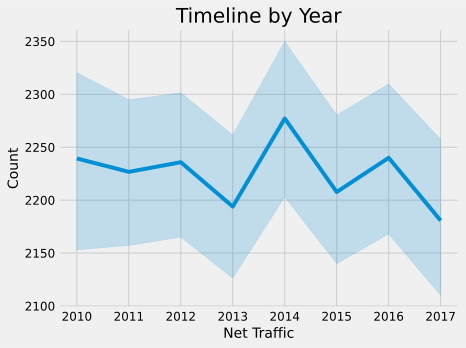

In [56]:
# Rider count per year

sns.lineplot(x = 'year', y = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Timeline by Year');
plt.xlabel('Net Traffic');
plt.ylabel('Count');
plt.xticks(rotation=0);

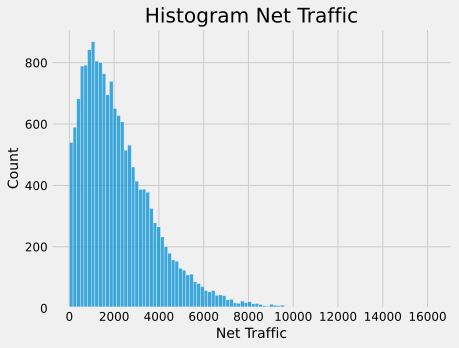

In [57]:
# Histogram of Riders 

sns.histplot(x = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Histogram Net Traffic');
plt.xlabel('Net Traffic');
plt.ylabel('Count');
plt.xticks(rotation=0);

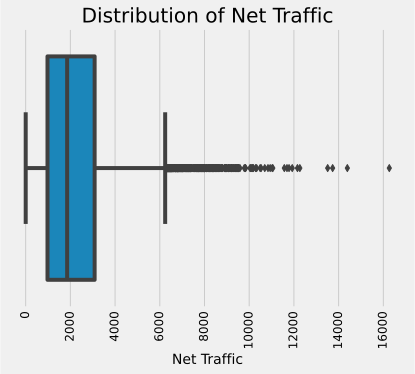

In [52]:
# Boxplot of Riders 

sns.boxplot(x = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Traffic');
plt.xlabel('Net Traffic');
plt.xticks(rotation=90);

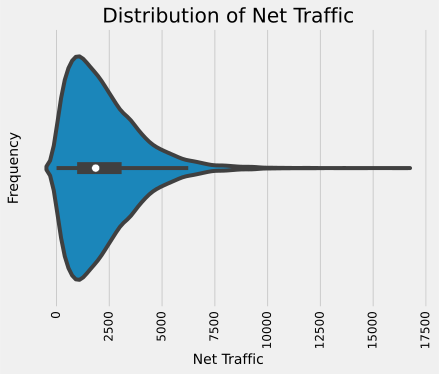

In [49]:
sns.violinplot(x=df_pandas.traffic);
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Traffic');
plt.xlabel('Net Traffic');
plt.ylabel('Frequency');
plt.xticks(rotation=90);
plt.savefig('violin_before.png', bbox_inches='tight');

## Timelapse by week of the year

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

In [87]:
weekly_timelapse_df = df_pandas.groupby(['weekofyear'])[['traffic']].sum().reset_index().copy()
weekly_timelapse_df['pct_change'] = weekly_timelapse_df.traffic.pct_change()
weekly_timelapse_df['pct_change'].iloc[0] = 0
weekly_timelapse_df['pct_total'] = weekly_timelapse_df['traffic'].apply(lambda x: x / weekly_timelapse_df.traffic.sum())

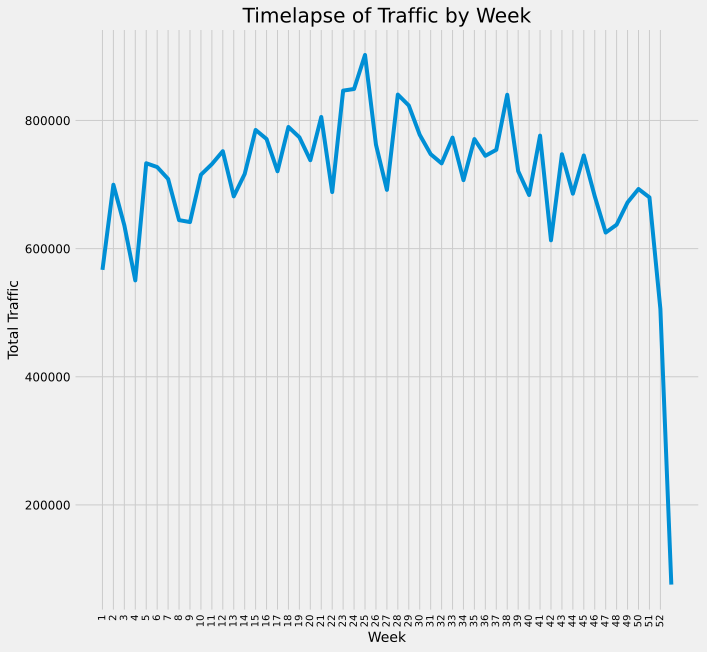

In [89]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weekly_timelapse_df, x='weekofyear', y='traffic');
plt.title('Timelapse of Traffic by Week');
plt.xlabel('Week');
plt.ylabel('Total Traffic');
plt.ticklabel_format(axis='y', style='plain');
plt.xticks(np.linspace(1,52,52), rotation=90, fontsize=10);


## Timelapse by day on year

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

The overall mean is at 2221 with a standard deviation of 890. The variance is quite high with a value above 790k

In [ ]:
daily_timelapse_df = df_pandas.groupby(['date'])[['traffic']].mean().reset_index()
daily_timelapse_df['pct_change'] = daily_timelapse_df.traffic.pct_change()

In [125]:
np.mean(daily_timelapse_df.traffic)

2221.982826972509

In [131]:
np.std(daily_timelapse_df.traffic)

890.814224958863

In [133]:
np.var(daily_timelapse_df.traffic, axis=0)

793549.9833890597

In [130]:
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_timelapse_df, x='date', y='traffic');
plt.title('Timelapse of Traffic by Day')
plt.xlabel('Date')
plt.ylabel('Average Traffic')
plt.xticks(rotation=90);
plt.savefig('trafficbyday.png', bbox_inches='tight');

In [ ]:
## Average monthly traffic

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

The overall mean is at 2221 with a standard deviation of 890. The variance is quite high with a value above 790k

In [92]:
monthly_df = df_pandas.groupby('month')[['traffic']].sum().reset_index().copy()

In [95]:
monthly_df['pct_change'] = monthly_df.traffic.pct_change()
monthly_df['pct_change'].iloc[0] = 0
monthly_df['pct_total'] = monthly_df['traffic'].apply(lambda x: x / monthly_df.traffic.sum())

In [96]:
monthly_timelapse = df_pandas.groupby('month')[['traffic']].mean().reset_index().copy()

In [123]:
np.mean(monthly_timelapse)

traffic   2225.85
dtype: float64

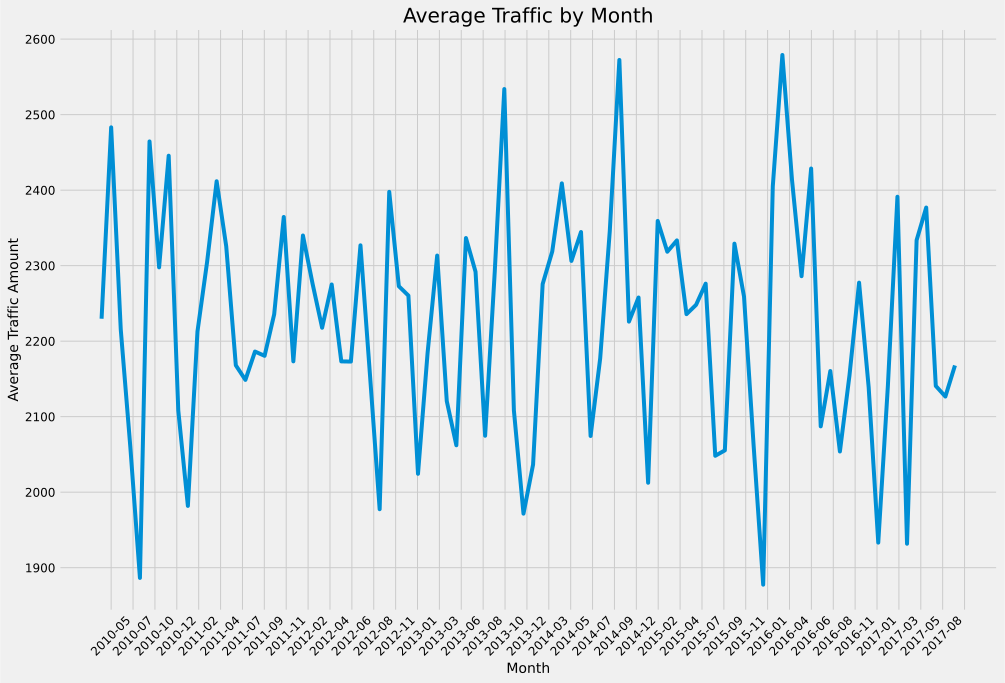

In [112]:
plt.figure(figsize=(15,10))
plt.plot(monthly_timelapse.month, monthly_timelapse.traffic);
plt.xlabel('Month')
plt.xticks(np.linspace(1,90,40));
plt.xlabel('Month');
plt.xticks(rotation=45);
plt.ylabel('Average Traffic Amount');
plt.title('Average Traffic by Month');
plt.savefig('avgtrafficbymonth.png', bbox_inches='tight')

In [126]:
dayofweek_df = df_pandas.groupby('dayofweek')[['traffic']].sum()
dayofweek_df['pct_change'] = dayofweek_df.traffic.pct_change()
dayofweek_df['pct_change'].iloc[0] = ((dayofweek_df.traffic.iloc[0] - dayofweek_df.traffic.iloc[6]) / dayofweek_df.traffic.iloc[6])
dayofweek_df['pct_total'] = dayofweek_df['traffic'].apply(lambda x: x / dayofweek_df.traffic.sum())

Text(0.5, 1.0, 'Total Riders by Day of Week')

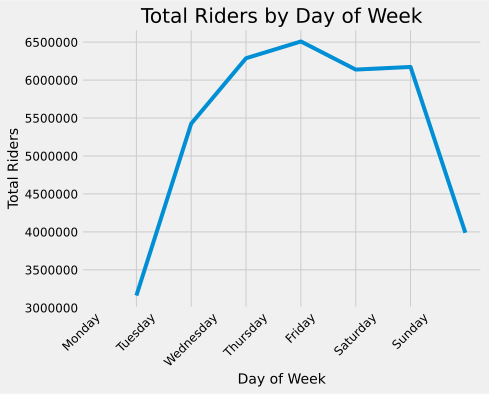

In [127]:
plt.plot(dayofweek_df.index, dayofweek_df.traffic);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Day of Week')
plt.ylabel('Total Riders')
plt.title('Total Riders by Day of Week')


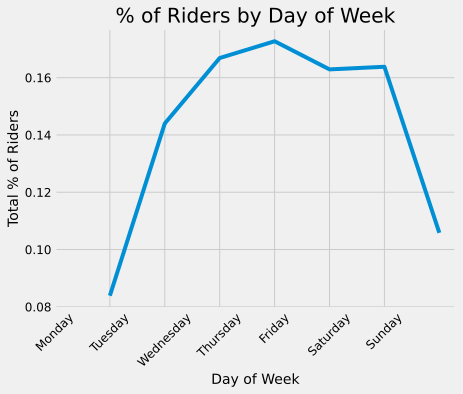

In [128]:
plt.plot(dayofweek_df.index, dayofweek_df.pct_total);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Total % of Riders');
plt.xlabel('Day of Week');
plt.title('% of Riders by Day of Week');
plt.savefig('pct_riders_dayofweek.png', bbox_inches='tight');